In [ ]:
!pip install open_clip_torch

In [ ]:
import json
from PIL import Image
import requests
from io import BytesIO
import torch
import open_clip
from tqdm import tqdm
with open('documents.jsonl', 'r') as json_file:
  json_list = list(json_file)
data = []
for json_str in json_list:
  result = json.loads(json_str)
  data.append(result)

In [ ]:
with open('items_ins_v2_1000.json', 'r') as f:
  data_ins = json.load(f)

In [ ]:
model, _, preprocess = open_clip.create_model_and_transforms('ViT-H-14', 'laion2b_s32b_b79k')
tokenizer = open_clip.get_tokenizer('ViT-H-14')

In [ ]:
scores = []
for i in tqdm(range(len(data))):
  txt = data[i]['contents']
  url = data[i]['product']['images'][0]
  if url == '':
    continue
  response = requests.get(url)
  img = Image.open(BytesIO(response.content))
  image = preprocess(img).unsqueeze(0)
  text = tokenizer([txt])
  with torch.no_grad(), torch.cuda.amp.autocast():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    text_probs = (100.0 * image_features @ text_features.T)
    scores.append(text_probs[0][0].item())

100%|██████████| 1000/1000 [19:31<00:00,  1.17s/it]


Text(0.5, 1.0, 'Distribution of CLIP Score')

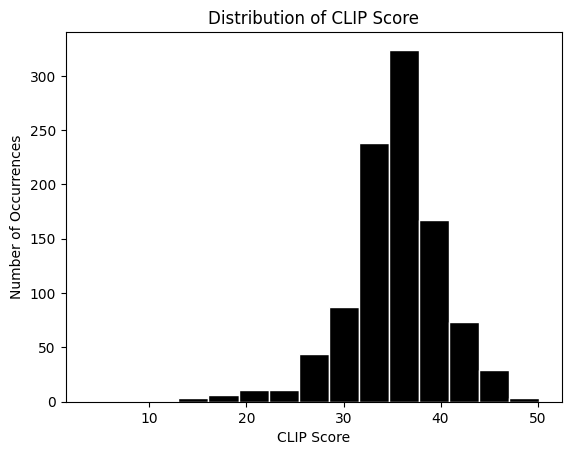

In [ ]:
import matplotlib.pyplot as plt

plt.hist(scores, color='black', ec='white', bins=15)
plt.xlabel("CLIP Score")
plt.ylabel("Number of Occurrences")
plt.title("Distribution of CLIP Score")

In [ ]:
scores_ins = []
for i in tqdm(range(len(data))):
  id = data[i]['id']
  url = data[i]['product']['images'][0]
  if url == '' or 'instruction' not in data_ins[id]:
    continue
  txt = data_ins[id]['instruction']
  response = requests.get(url)
  img = Image.open(BytesIO(response.content))
  image = preprocess(img).unsqueeze(0)
  text = tokenizer([txt])
  with torch.no_grad(), torch.cuda.amp.autocast():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    text_probs = (100.0 * image_features @ text_features.T)
    scores_ins.append(text_probs[0][0].item())

100%|██████████| 1000/1000 [08:42<00:00,  1.91it/s]


Text(0.5, 1.0, 'Distribution of CLIP Score for Image-Instruction Pair')

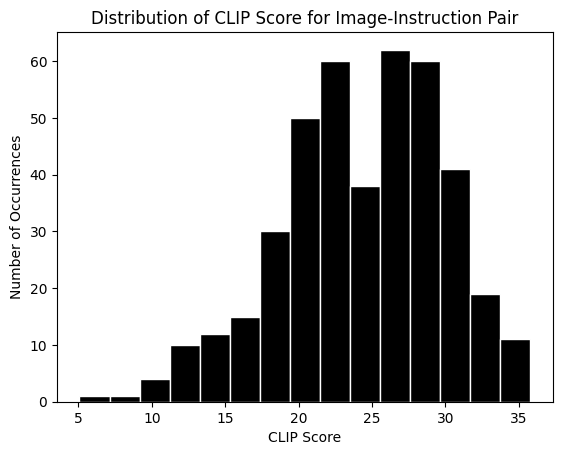

In [ ]:
import matplotlib.pyplot as plt

plt.hist(scores_ins[:414], color='black', ec='white', bins=15)
plt.xlabel("CLIP Score")
plt.ylabel("Number of Occurrences")
plt.title("Distribution of CLIP Score for Image-Instruction Pair")

In [ ]:
import random
scores_ins_rdm = []
all_ins = list(data_ins.keys())
for i in tqdm(range(len(data))):
  id = data[i]['id']
  url = data[i]['product']['images'][0]
  if url == '':
    continue
  id_rdm = random.choice(all_ins)
  while id_rdm == id or 'instruction' not in data_ins[id_rdm]:
    id_rdm = random.choice(all_ins)
  txt = data_ins[id_rdm]['instruction']
  response = requests.get(url)
  img = Image.open(BytesIO(response.content))
  image = preprocess(img).unsqueeze(0)
  text = tokenizer([txt])
  with torch.no_grad(), torch.cuda.amp.autocast():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    text_probs = (100.0 * image_features @ text_features.T)
    scores_ins.append(text_probs[0][0].item())

100%|██████████| 1000/1000 [20:40<00:00,  1.24s/it]


Text(0.5, 1.0, 'Distribution of CLIP Score for Image-Instruction Pair')

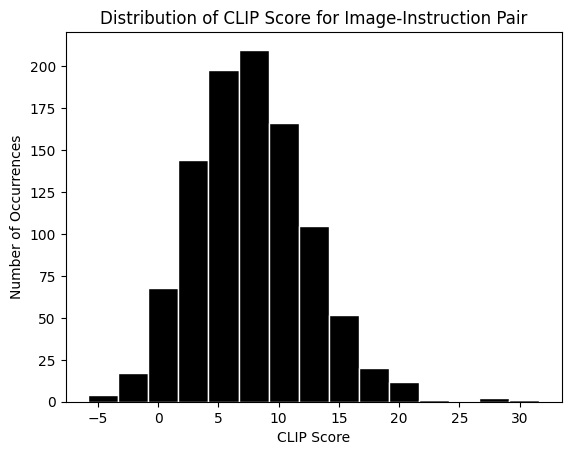

In [ ]:
import matplotlib.pyplot as plt
plt.hist(scores_ins[414:], color='black', ec='white', bins=15)
plt.xlabel("CLIP Score")
plt.ylabel("Number of Occurrences")
plt.title("Distribution of CLIP Score for Image-Instruction Pair")

In [ ]:
import random
scores_ins_diff = []
all_ins = list(data_ins.keys())
for i in tqdm(range(len(data))):
  id = data[i]['id']
  url = data[i]['product']['images'][0]
  if url == '' or 'instruction' not in data_ins[id]:
    continue
  id_rdm = random.choice(all_ins)
  while id_rdm == id or 'instruction' not in data_ins[id_rdm]:
    id_rdm = random.choice(all_ins)
  txt = data_ins[id]['instruction']
  txt_rdm = data_ins[id_rdm]['instruction']
  response = requests.get(url)
  img = Image.open(BytesIO(response.content))
  image = preprocess(img).unsqueeze(0)
  text = tokenizer([txt, txt_rdm])
  with torch.no_grad(), torch.cuda.amp.autocast():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    text_probs = (100.0 * image_features @ text_features.T)
    scores_ins_diff.append((text_probs[0][0].item(), text_probs[0][1].item()))

100%|██████████| 1000/1000 [08:58<00:00,  1.86it/s]


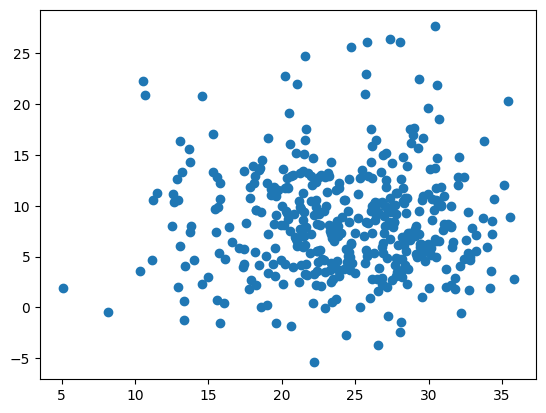

In [ ]:
x, y = zip(*scores_ins_diff)
plt.scatter(x, y)